In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [13]:
from IPython.display import HTML
from __future__ import print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import (
    SolutionResult
)
from underactuated import (
    PlanarRigidBodyVisualizer
)

from dircol import make_real_dircol_mp


expmt = "acrobot"
seed  = 1776
dircol, tree = make_real_dircol_mp(expmt=expmt, seed=seed)

# Explcitly set the cost function here.
R = 10  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R*u[0]**2)

140142084998768
used solver:  SNOPT


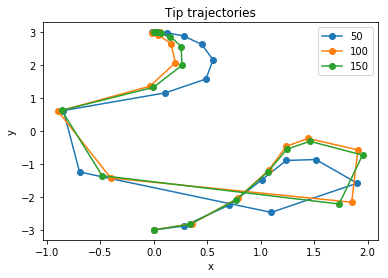

In [14]:
plt.figure()
plt.title('Tip trajectories')
plt.xlabel('x')
plt.ylabel('y')

vis_cb_counter = 0
if expmt == "cartpole":
    def state_to_tip_coord(state_vec):
        # State: (x, theta, x_dot, theta_dot)
        x, theta, _, _ = state_vec
        pole_length = 0.5 # manually looked this up
        return (x-pole_length*np.sin(theta), pole_length-np.cos(theta))
else:
    def state_to_tip_coord(state_vec):
        # State: (theta1, theta2, theta1_dot, theta2_dot)
        theta1, theta2, _, _ = state_vec
        link1_length = 1
        link2_length = 2
        return (-link1_length*np.sin(theta1)  -link2_length*np.sin(theta1+theta2), 
                -link1_length*np.cos(theta1)  -link2_length*np.cos(theta1+theta2))
def MyVisualization(sample_times, values):
    global vis_cb_counter
    global state_to_tip_coord

    vis_cb_counter += 1
    if vis_cb_counter % 50 != 0:
        return
    
    coords = [state_to_tip_coord(state) for state in values.T]
    x, y = zip(*coords)
    plt.plot(x, y, '-o', label=vis_cb_counter)

print(id(dircol))
dircol.AddStateTrajectoryCallback(MyVisualization)

result = dircol.Solve()
assert(result == SolutionResult.kSolutionFound)
print("used solver: ", dircol.GetSolverId().name())

# plt.show()
plt.legend()

# x_trajectory = dircol.ReconstructStateTrajectory()

In [15]:
print(dircol.ReconstructStateTrajectory())

In [16]:
x_trajectory = dircol.ReconstructStateTrajectory()

if expmt == "cartpole":
    vis = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
else:
    print("created acrobot vis")
#     print(x_trajectory)
    vis = PlanarRigidBodyVisualizer(tree, xlim=[-4., 4.], ylim=[-4., 4.])
ani = vis.animate(x_trajectory, repeat=True)

# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

created acrobot vis


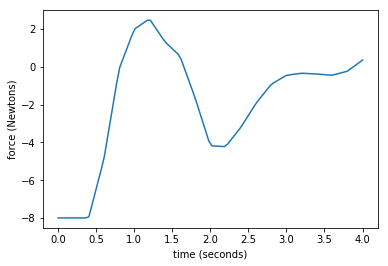

In [17]:
u_trajectory = dircol.ReconstructInputTrajectory()
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('force (Newtons)')

plt.show()